# Zoomate

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
'''
IMAGE PROCESSING
'''
import sys
import argparse
import cv2
from libfaceid.detector import FaceDetectorModels, FaceDetector
from libfaceid.encoder  import FaceEncoderModels, FaceEncoder
from libfaceid.pose import FacePoseEstimatorModels, FacePoseEstimator
from libfaceid.age import FaceAgeEstimatorModels, FaceAgeEstimator
from libfaceid.gender import FaceGenderEstimatorModels, FaceGenderEstimator
from libfaceid.emotion import FaceEmotionEstimatorModels, FaceEmotionEstimator

Using TensorFlow backend.


In [3]:
'''
STREAMING
'''
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
import time

In [4]:
'''
STREAMING CONTROL
'''
import threading
import asyncio

Button(description='Show Result', style=ButtonStyle())

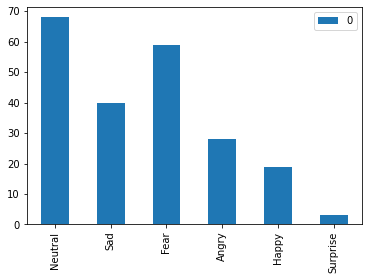

In [5]:
'''
BUTTON CONTROLS
'''
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox
streaming_toggle = widgets.ToggleButton(
                        value=False,
                        description='Start Streaming',
                        disabled=False,
                        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
                        tooltip='Streaming',
                        icon='play'
                    )

show_result_button = widgets.Button(description="Show Result")
display(show_result_button)

In [6]:
INPUT_DIR_DATASET               = "datasets"
INPUT_DIR_MODEL_DETECTION       = "models/detection/"
INPUT_DIR_MODEL_ENCODING        = "models/encoding/"
INPUT_DIR_MODEL_TRAINING        = "models/training/"
INPUT_DIR_MODEL_ESTIMATION      = "models/estimation/"

In [7]:
RESOLUTION_QVGA   = (320, 240)
RESOLUTION_VGA    = (640, 480)
RESOLUTION_HD     = (1280, 720)
RESOLUTION_FULLHD = (1920, 1080)

In [8]:
'''
STREAMING HELPER FUNCTIONS
'''
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def show_init_screen():
    image_data = cv2.imread("init_screen.jpeg")
    image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGBA)
    image_data = cv2.flip(image_data, 0)
    myImage.data_source.data['image']=[image_data]
    push_notebook()

def cam_init(cam_index, width, height): 
    cap = cv2.VideoCapture(cam_index)
    if sys.version_info < (3, 0):
        cap.set(cv2.cv.CV_CAP_PROP_FPS, 30)
        cap.set(cv2.cv.CV_CAP_PROP_FRAME_WIDTH,  width)
        cap.set(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT, height)
    else:
        cap.set(cv2.CAP_PROP_FPS, 30)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH,  width)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    return cap

def label_face(frame, face_rect, face_id, confidence):
    (x, y, w, h) = face_rect
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 255), 1)
    if face_id is not None:
        cv2.putText(frame, "{} {:.2f}%".format(face_id, confidence), 
            (x+5,y+h-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

In [9]:
output_notebook()
emotions = []

cam_index = 0
cam_resolution = RESOLUTION_QVGA
model_detector=FaceDetectorModels.HAARCASCADE
model_poseestimator=FacePoseEstimatorModels.DEFAULT
model_ageestimator=FaceAgeEstimatorModels.DEFAULT
model_genderestimator=FaceGenderEstimatorModels.DEFAULT
model_emotionestimator=FaceEmotionEstimatorModels.DEFAULT


# Initialize the camera
camera = cam_init(cam_index, cam_resolution[0], cam_resolution[1])

ret, frame = camera.read()
frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
frame=cv2.flip(frame, 0) # because Bokeh flips vertically

width=frame.shape[1]
height=frame.shape[0]
p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width, height=height)
myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
show(p, notebook_handle=True)

print("Camera Reesolution: {0}X{1}".format(width, height))
push_notebook()


try:
    # Initialize face detection
    face_detector = FaceDetector(model=model_detector, path=INPUT_DIR_MODEL_DETECTION)#, optimize=True)
    # Initialize face pose/age/gender estimation
    face_pose_estimator = FacePoseEstimator(model=model_poseestimator, path=INPUT_DIR_MODEL_ESTIMATION)
    face_age_estimator = FaceAgeEstimator(model=model_ageestimator, path=INPUT_DIR_MODEL_ESTIMATION)
    face_gender_estimator = FaceGenderEstimator(model=model_genderestimator, path=INPUT_DIR_MODEL_ESTIMATION)
    face_emotion_estimator = FaceEmotionEstimator(model=model_emotionestimator, path=INPUT_DIR_MODEL_ESTIMATION)
except:
    print("Warning, check if models and trained dataset models exists!")
(age, gender, emotion) = (None, None, None)


while True:

    # Capture frame from webcam
    ret, frame = camera.read()
    if frame is None:
        print("Error, check if camera is connected!")
        break

    # Detect and identify faces in the frame
    faces = face_detector.detect(frame)
    for (index, face) in enumerate(faces):
        (x, y, w, h) = face

        # Detect age, gender, emotion
        face_image = frame[y:y+h, h:h+w]
        age = face_age_estimator.estimate(frame, face_image)
        gender = face_gender_estimator.estimate(frame, face_image)
        emotion = face_emotion_estimator.estimate(frame, face_image)
        emotions.append(emotion)

        # Detect and draw face pose locations
        shape = face_pose_estimator.detect(frame, face)
        face_pose_estimator.add_overlay(frame, shape)

        # Display age, gender, emotion

    cv2.putText(frame, "Age: {}".format(age), 
        (x, y-45), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Gender: {}".format(gender), 
        (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Emotion: {}".format(emotion), 
        (x, y-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
    # Display updated frame to Jupyter Notebook
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    frame=cv2.flip(frame, 0) # because Bokeh flips vertically


    myImage.data_source.data['image']=[frame]
    push_notebook()
    time.sleep(0.2)

Loading BokehJS ...

Camera Reesolution: 640X480
Instructions for updating:
Colocations handled automatically by placer.


KeyboardInterrupt: 

In [10]:
camera.release()
cv2.destroyAllWindows()

In [11]:
import pandas
from collections import Counter
def on_button_clicked(b):
    letter_counts = Counter(emotions)
    df = pandas.DataFrame.from_dict(letter_counts, orient='index')
    df.plot(kind='bar')

In [12]:
show_result_button.on_click(on_button_clicked)

In [ ]:
print(emotions)